In [1]:
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  fonts-nanum
0 upgraded, 1 newly installed, 0 to remove and 19 not upgraded.
Need to get 10.3 MB of archives.
After this operation, 34.1 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 fonts-nanum all 20200506-1 [10.3 MB]
Fetched 10.3 MB in 2s (5,376 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 78, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting previously unselected package fonts-nanum.
(Reading database ... 120874 files and dire

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
plt.rc('font', family='NanumBarunGothic')

# 데이터셋 Load

In [3]:
#데이터 호출
df = pd.read_csv('product_inventory_A.csv', index_col=0)
df

,제품,생산량,출고량,현재고량
생산일자,,,,
2018-01-02,A,0,4000,29650
2018-01-03,A,0,6000,23650
2018-01-04,A,0,6000,17650
2018-01-05,A,0,5000,12650
2018-01-08,A,42000,6000,48650
...,...,...,...,...
2019-11-08,A,0,8000,128550
2019-11-11,A,0,15000,113550
2019-11-12,A,43300,11000,145850


# 휴일에 대한 데이터 보간 (필수 아님)

In [4]:
#휴일 유무에 따른 예측값의 변화를 확인할 때 사용할 데이터셋을 위해 타임스탬프 준비
#데이터에서 빈 요일을 보간할 때 사용
import datetime
firstTime = pd.Timestamp(2018, 1, 1,0,0,0)
curTime = firstTime
lastTime = pd.Timestamp(2019, 10, 18,0,0,0) # 2019-10-18,B,0,4000,165100
allTimeStamp = [curTime]
while True:
  curTime = curTime + datetime.timedelta(days=1)
  allTimeStamp.append(curTime)
  if curTime == lastTime:
    break

In [5]:
#데이터셋을 보간하여 allday라는 데이터프레임으로 저장
allday = pd.DataFrame(columns = ['생산일자','제품','생산량','출고량','현재고량'])
allday.loc[0] = [firstTime,'A',0,0,33650]
a = list(df.index)
for i in range(1,len(allTimeStamp)):
  if allTimeStamp[i] in a:
    last = df.loc[allTimeStamp[i]]
    allday.loc[len(allday)] = [allTimeStamp[i],'A',last['생산량'],last['출고량'],last['현재고량']]
  else:
    last = allday.loc[i-1]
    allday.loc[len(allday)] = [allTimeStamp[i],'A',0,0,last['현재고량']]

In [6]:
allday.set_index('생산일자', inplace=True)

# 데이터 EDA 및 데이터에 대한 컴포넌트 분석

In [7]:
df1 = df[['생산량']]
df2 = df[['출고량']]
df3 = df[['현재고량']]

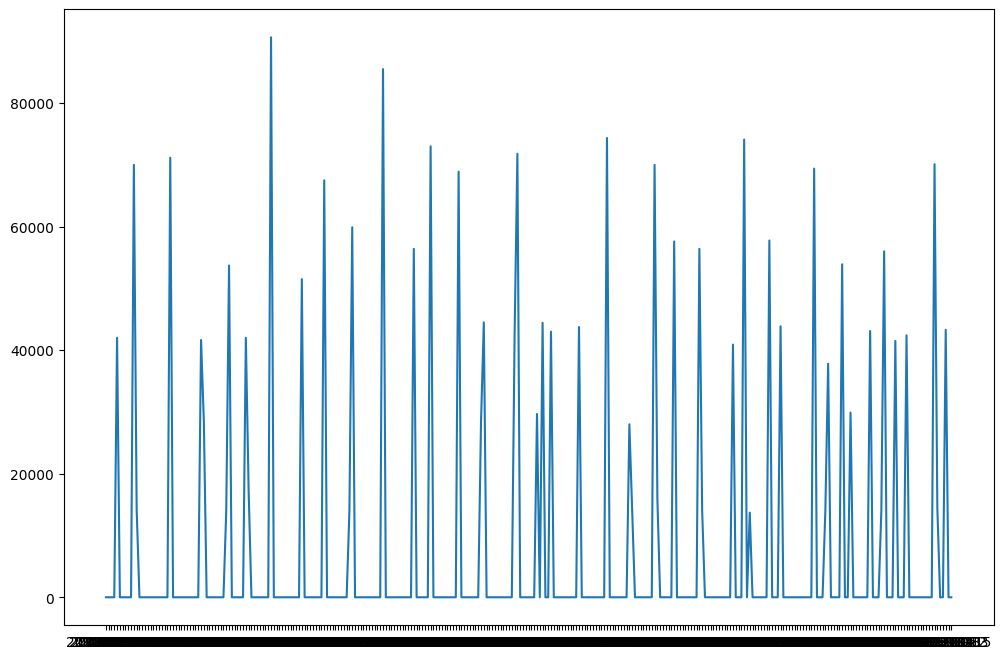

In [8]:
#생산량 데이터 모양 확인
plt.figure(figsize= (12,8))
plt.plot(df1)

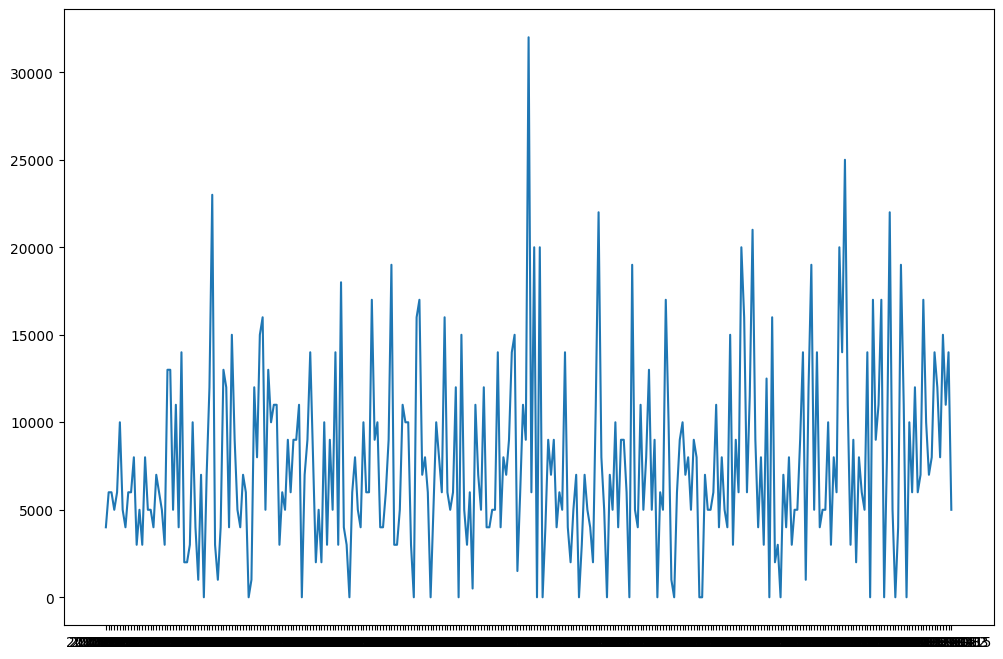

In [9]:
#출고량 데이터 모양 확인
plt.figure(figsize= (12,8))
plt.plot(df2)

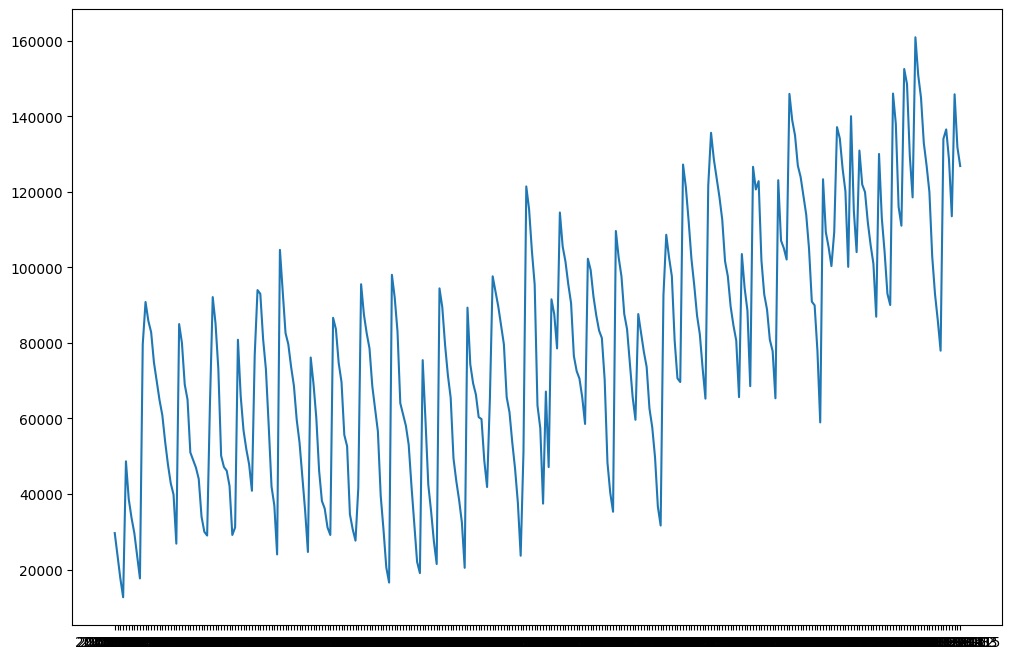

In [10]:
#현재고량 데이터 모양 확인
plt.figure(figsize= (12,8))
plt.plot(df3)

# 2. 데이터 정상성 확인

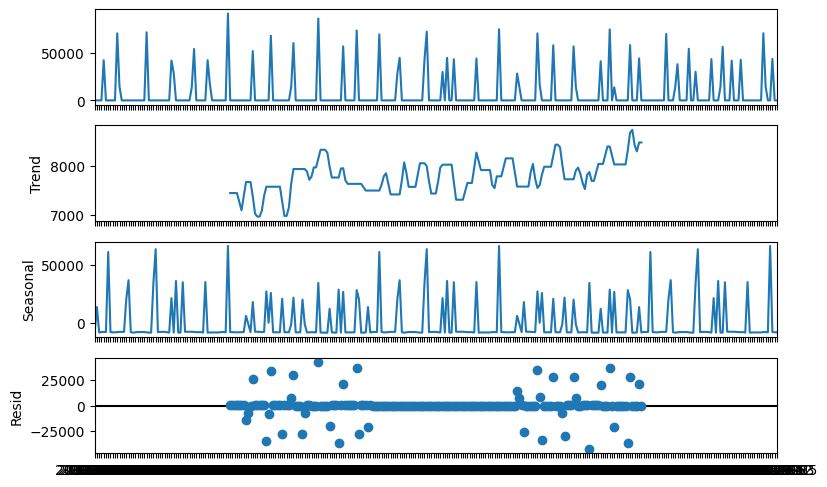

In [11]:
#생산량 시계열 분해
from statsmodels.tsa.seasonal import seasonal_decompose
dec = seasonal_decompose(df1, model='additive', period=120)
fig = dec.plot()
fig.set_size_inches(9, 5)

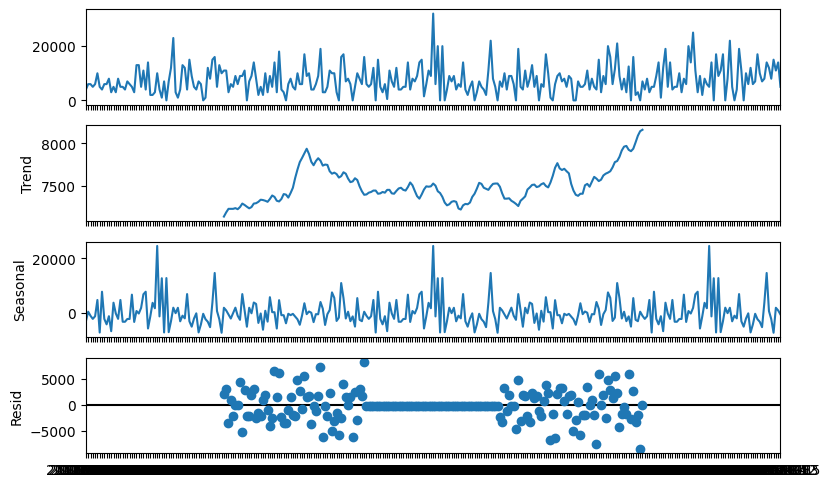

In [12]:
#출고량 시계열 분해
from statsmodels.tsa.seasonal import seasonal_decompose
dec = seasonal_decompose(df2, model='additive', period=120)
fig = dec.plot()
fig.set_size_inches(9, 5)

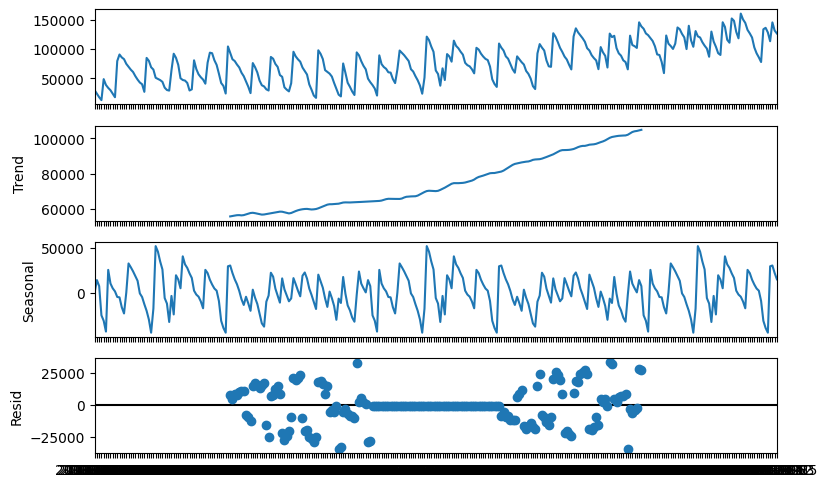

In [13]:
#현재고량 시계열 분해
from statsmodels.tsa.seasonal import seasonal_decompose
dec = seasonal_decompose(df3, model='additive', period=120)
fig = dec.plot()
fig.set_size_inches(9, 5)

In [14]:
from statsmodels.tsa.stattools import adfuller

## ADF Test

In [15]:
target_df = df2

In [16]:
#ADF 테스트
adfuller(target_df)

(-17.80887337029981,
 3.195338441443072e-30,
 0,
 302,
 {'1%': -3.4521902441030963,
  '5%': -2.871158406898617,
  '10%': -2.5718948388228586},
 5724.453238260673)

# 3. 비정상적인 데이터를 정상 데이터로 변환

In [17]:
from sklearn.model_selection import train_test_split
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf #ACF, PACF 그래프

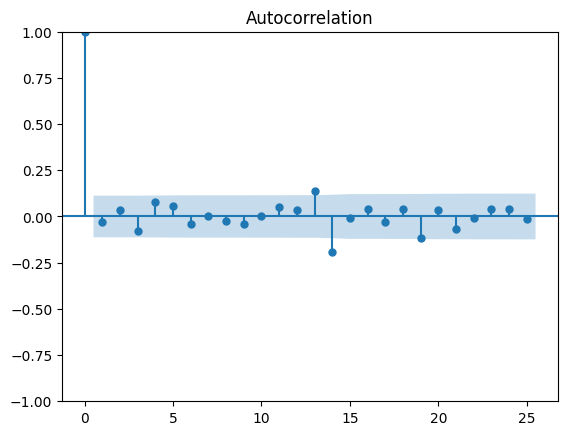

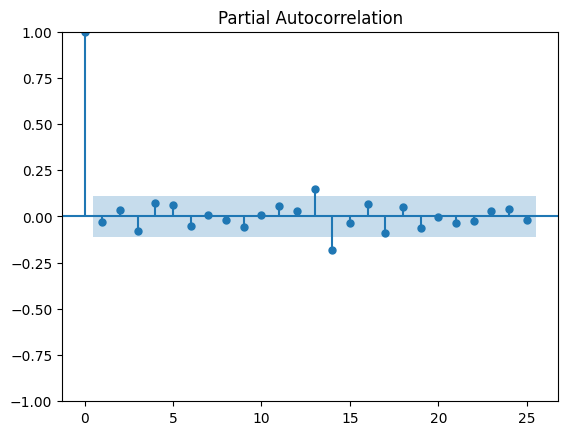

In [18]:
#ACF, PACF 그래프
plot_acf(target_df)
plot_pacf(target_df)
plt.show()

## Differencing

In [19]:
#훈련, 실험 데이터 분리
train_df, test_df = train_test_split(target_df, test_size = 0.2, shuffle = False)

In [20]:
# 차분 데이터 저장
diff_train_df = train_df.diff().dropna()
diff_test_df = test_df.diff().dropna()

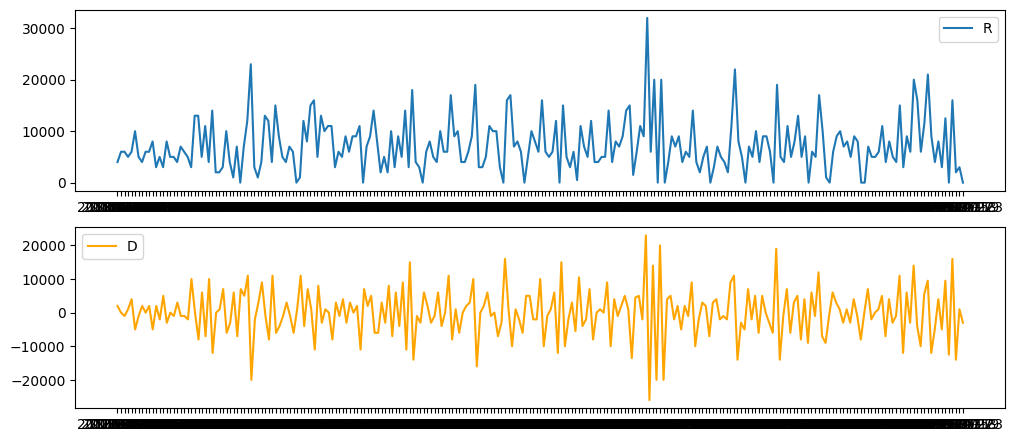

In [21]:
# 시각화
plt.figure(figsize= (12,8))
plt.subplot(311)
plt.plot(train_df)
plt.legend('Raw Data')
plt.subplot(312)
plt.plot(diff_train_df, 'orange')
plt.legend('Differenced Data')
plt.show()

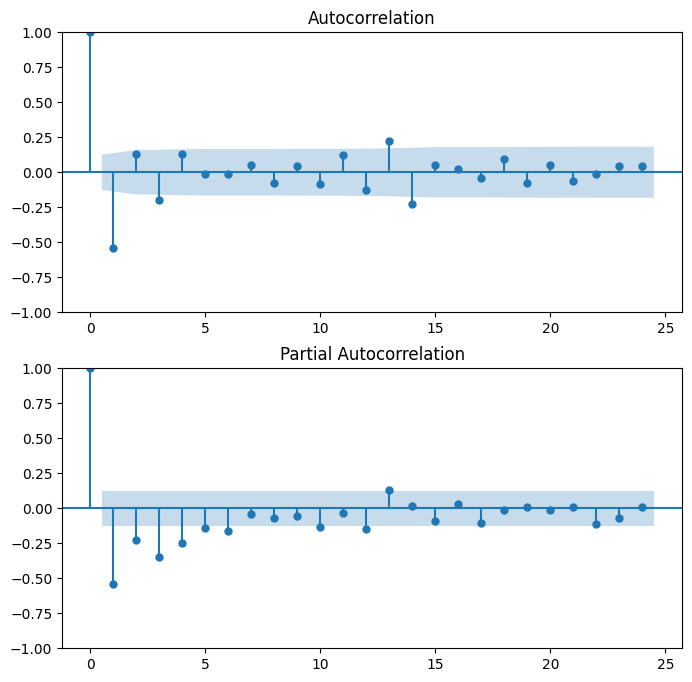

In [22]:
fig, ax = plt.subplots(2,1, figsize=(8,8))
plot_acf(diff_train_df, ax[0])
plot_pacf(diff_train_df, ax[1])
plt.show()

# 예측 모델 사용하기


In [23]:
# train_df = diff_train_df
# train_df = diff_test_df

## ARIMA

In [24]:
import itertools
import statsmodels.api as sm

In [25]:
#최적의 p,d,q 구하기
#비교해볼 파라미터 적용해보기
p = range(0,3)
d = range(0,3)
q = range(0,3)
pdq = list(itertools.product(p, d,q))

aic = []
for i in pdq:
    model = sm.tsa.arima.ARIMA(train_df, order = (i))
    model_fit = model.fit()
    print(f'ARIMA: {i} >> AIC : {round(model_fit.aic,2)}')
    aic.append(round(model_fit.aic,2))

# Search optimal parameters
optimal = [(pdq[i],j) for i, j in enumerate(aic) if j == min(aic)]
optimal

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


ARIMA: (0, 0, 0) >> AIC : 4817.22
ARIMA: (0, 0, 1) >> AIC : 4818.84
ARIMA: (0, 0, 2) >> AIC : 4820.69
ARIMA: (0, 1, 0) >> AIC : 4972.03
ARIMA: (0, 1, 1) >> AIC : 4804.81


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


ARIMA: (0, 1, 2) >> AIC : 4806.53
ARIMA: (0, 2, 0) >> AIC : 5222.45
ARIMA: (0, 2, 1) >> AIC : 4958.97


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/pyth

ARIMA: (0, 2, 2) >> AIC : 4800.83
ARIMA: (1, 0, 0) >> AIC : 4818.79
ARIMA: (1, 0, 1) >> AIC : 4818.71


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


ARIMA: (1, 0, 2) >> AIC : 4819.55
ARIMA: (1, 1, 0) >> AIC : 4890.88
ARIMA: (1, 1, 1) >> AIC : 4806.51


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


ARIMA: (1, 1, 2) >> AIC : 4806.47
ARIMA: (1, 2, 0) >> AIC : 5049.98
ARIMA: (1, 2, 1) >> AIC : 4878.59


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


ARIMA: (1, 2, 2) >> AIC : 4802.54
ARIMA: (2, 0, 0) >> AIC : 4820.39
ARIMA: (2, 0, 1) >> AIC : 4819.84
ARIMA: (2, 0, 2) >> AIC : 4815.26
ARIMA: (2, 1, 0) >> AIC : 4880.53


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


ARIMA: (2, 1, 1) >> AIC : 4807.99


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


ARIMA: (2, 1, 2) >> AIC : 4807.4
ARIMA: (2, 2, 0) >> AIC : 5011.6
ARIMA: (2, 2, 1) >> AIC : 4889.2


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


ARIMA: (2, 2, 2) >> AIC : 4879.86


[((0, 2, 2), 4800.83)]

In [26]:
#모델 정보 확인
model = sm.tsa.arima.ARIMA(train_df, order = optimal[0][0])
model_fit = model.fit()
model_fit.summary()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                    출고량   No. Observations:                  242
Model:                 ARIMA(0, 2, 2)   Log Likelihood               -2397.415
Date:                Sat, 11 Nov 2023   AIC                           4800.829
Time:                        00:04:43   BIC                           4811.271
Sample:                             0   HQIC                          4805.037
                                - 242                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -1.9999      0.069    -28.950      0.000      -2.135      -1.864
ma.L2          0.9999      0.069     14.485      0.000       0.865       1.135
sigma2       2.55e+07   5.42e-09   4.71e+15      0.000    2.55e+07    2.55e+07
===================================================================================
Ljung-Box (L1) (Q):                   0.55   Jarque-Bera (JB):                92.76
Prob(Q):                              0.46   Prob(JB):                         0.00
Heteroskedasticity (H):               1.39   Skew:                             1.11
Prob(H) (two-sided):                  0.14   Kurtosis:                         5.08
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.56e+30. Standard errors may be unstable.
"""

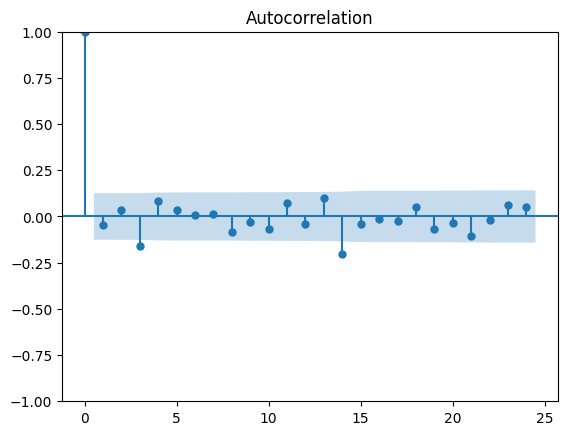

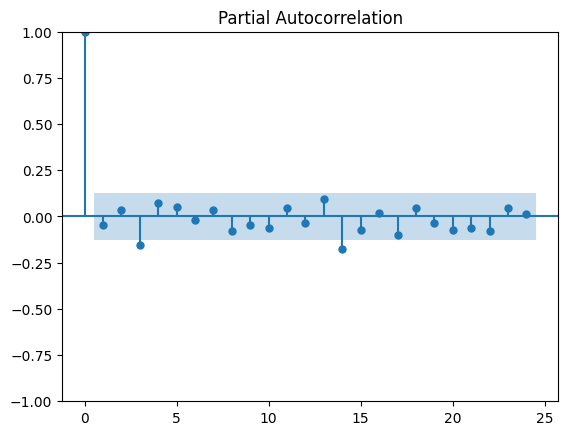

In [27]:
#최적 모델 적용시 acf,pacf확인
plot_acf(model_fit.resid)
plot_pacf(model_fit.resid)
plt.show()

In [28]:
#ADF 분석
adfuller(model_fit.resid)

(-10.204194040296391,
 5.862720002594528e-18,
 2,
 239,
 {'1%': -3.458010773719797,
  '5%': -2.8737103617125186,
  '10%': -2.5732559963936206},
 4517.338919092016)

In [29]:
#최적모델 세팅
model = sm.tsa.arima.ARIMA(train_df, order = optimal[0][0])
model_fit = model.fit()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [30]:
#예측 시작
result = model_fit.get_forecast(steps = len(test_df.index), alpha = 0.05).summary_frame()
result

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


출고량,mean,mean_se,mean_ci_lower,mean_ci_upper
242,7726.197703,5090.396133,-2250.795385,17703.190790
243,7730.393071,5090.898320,-2247.584285,17708.370428
244,7734.588440,5091.404544,-2244.381097,17713.557976
245,7738.783808,5091.914802,-2241.185816,17718.753433
246,7742.979177,5092.429094,-2237.998442,17723.956796
...,...,...,...,...
298,7961.138344,5124.697807,-2083.084790,18005.361477
299,7965.333713,5125.423928,-2080.312592,18010.980017
300,7969.529081,5126.154005,-2077.548147,18016.606309
301,7973.724450,5126.888035,-2074.791452,18022.240351


In [31]:
fc = tuple(result['mean'].values) # 예측값
se = tuple(result['mean_se'].values) # 표준오차
lower_coef = tuple(result['mean_ci_lower'].values) # 신뢰구간 최소
upper_coef = tuple(result['mean_ci_upper'].values) # 신뢰구간 최대

# 예측값 인덱스 넣기
fc_data = pd.Series(fc, index = test_df.index)

# 신뢰구간 인덱스 넣기
lower_data = pd.Series(lower_coef, index = test_df.index)
upper_data = pd.Series(upper_coef, index = test_df.index )

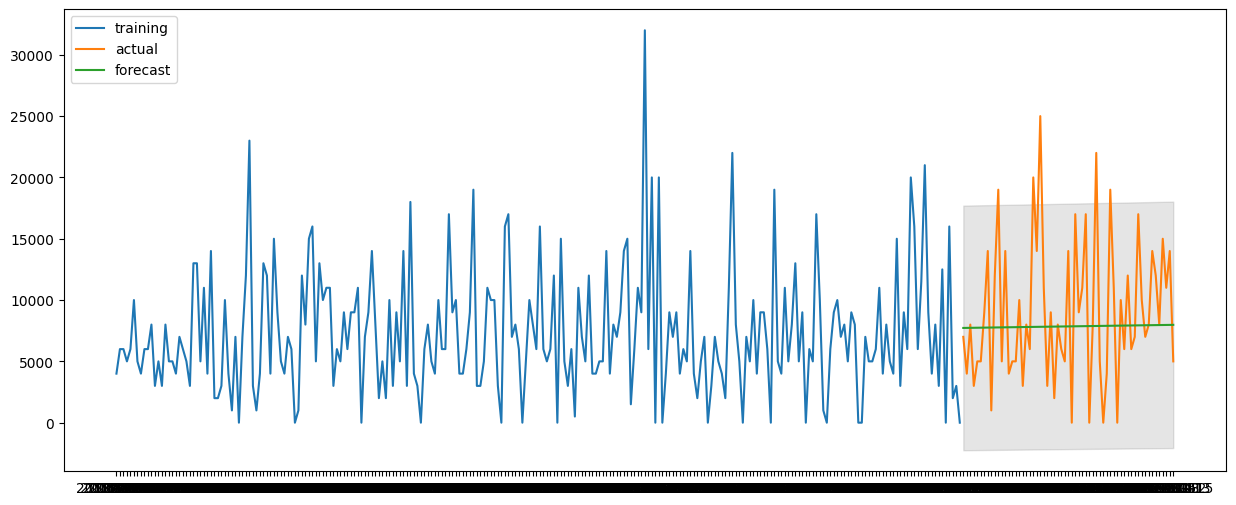

In [32]:
#시각화
plt.figure(figsize =(15, 6))
plt.plot(train_df, label = 'training')
plt.plot(test_df, label = 'actual')
plt.plot(fc_data, label = 'forecast')
plt.fill_between(test_df.index, lower_data, upper_data, color = 'black', alpha = 0.1)
plt.legend(loc = 'upper left')
plt.show()

In [33]:
result.mean()

출고량
mean              7852.058760
mean_se           5107.831959
mean_ci_lower    -2159.107917
mean_ci_upper    17863.225438
dtype: float64

In [34]:
rm = result.mean().values

In [35]:
rm[0]*3 # 3주

23556.176281238677

## SARIMAX

In [36]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from tqdm import tqdm

In [37]:
#최적 모델 찾기
p = range(0,3)
d = range(0,3)
q = range(0,3)
m = 24
pdq = list(itertools.product(p,d,q))
seasonal_pdq = [(x[0],x[1], x[2], m) for x in list(itertools.product(p,d,q))]

aic = []
params = []

with tqdm(total = len(pdq) * len(seasonal_pdq)) as pg:
    for i in pdq:
        for j in seasonal_pdq:
            pg.update(1)
            try:
                model = SARIMAX(train_df, order=(i), season_order = (j))
                model_fit = model.fit()
                aic.append(round(model_fit.aic,2))
                params.append((i,j))
            except:
                continue

  0%|          | 0/729 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['season_order']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so wi

In [38]:
#모델 정보 확인
optimal = [(params[i],j) for i,j in enumerate(aic) if j == min(aic)]
model_opt = SARIMAX(train_df, order = optimal[0][0][0], seasonal_order = optimal[0][0][1])
model_opt_fit = model_opt.fit()
model_opt_fit.summary()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                    출고량   No. Observations:                  242
Model:               SARIMAX(0, 2, 2)   Log Likelihood               -2397.415
Date:                Sat, 11 Nov 2023   AIC                           4800.829
Time:                        00:07:05   BIC                           4811.271
Sample:                             0   HQIC                          4805.037
                                - 242                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -1.9999      0.069    -28.950      0.000      -2.135      -1.864
ma.L2          0.9999      0.069     14.485      0.000       0.865       1.135
sigma2       2.55e+07   5.42e-09   4.71e+15      0.000    2.55e+07    2.55e+07
===================================================================================
Ljung-Box (L1) (Q):                   0.55   Jarque-Bera (JB):                92.76
Prob(Q):                              0.46   Prob(JB):                         0.00
Heteroskedasticity (H):               1.39   Skew:                             1.11
Prob(H) (two-sided):                  0.14   Kurtosis:                         5.08
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.56e+30. Standard errors may be unstable.
"""

### 데이터 예측

In [39]:
# 일주일치 출고량 예측
model = SARIMAX(train_df, order=optimal[0][0][0], seasonal_order=optimal[0][0][1])
model_fit = model.fit()
result = model_fit.get_forecast(steps = len(test_df.index), alpha = 0.05).summary_frame()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/

In [40]:
fc = tuple(result['mean'].values) # 예측값
se = tuple(result['mean_se'].values) # 표준오차
lower_coef = tuple(result['mean_ci_lower'].values) # 신뢰구간 최소
upper_coef = tuple(result['mean_ci_upper'].values) # 신뢰구간 최대

# 예측값 인덱스 넣기
fc_data = pd.Series(fc, index = test_df.index)

# 신뢰구간 인덱스 넣기
lower_data = pd.Series(lower_coef, index = test_df.index)
upper_data = pd.Series(upper_coef, index = test_df.index )

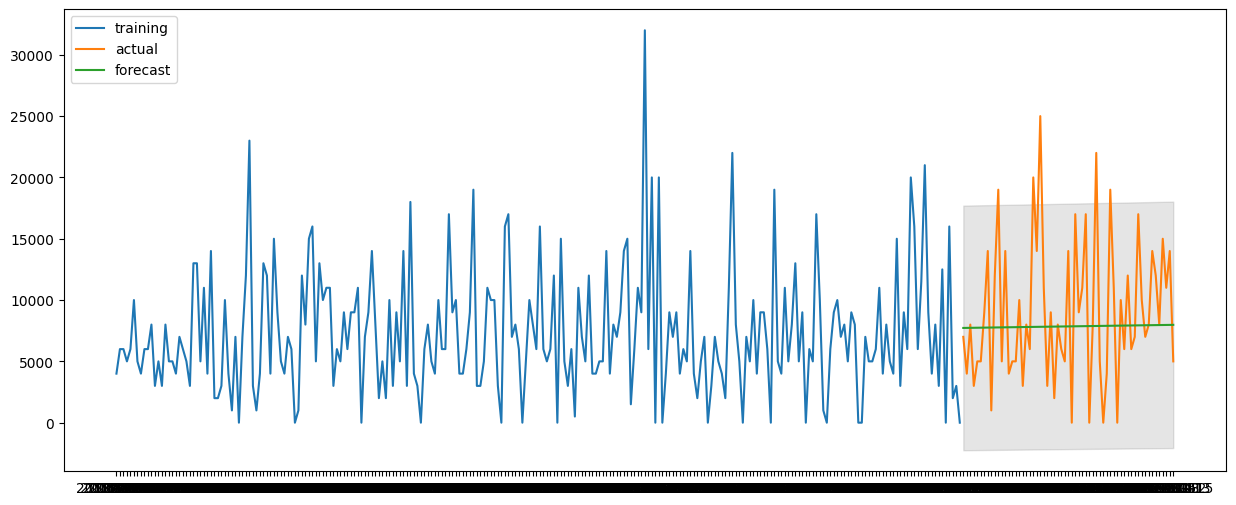

In [41]:
#시각화
plt.figure(figsize =(15, 6))
plt.plot(train_df, label = 'training')
plt.plot(test_df, label = 'actual')
plt.plot(fc_data, label = 'forecast')
plt.fill_between(test_df.index, lower_data, upper_data, color = 'black', alpha = 0.1)
plt.legend(loc = 'upper left')
plt.show()

In [42]:
result.mean()

출고량
mean              7852.058760
mean_se           5107.831959
mean_ci_lower    -2159.107917
mean_ci_upper    17863.225438
dtype: float64

In [43]:
# 1주일 출고량 * 3주
rm[0]*3

23556.176281238677

## PROPHET

In [98]:
train_size = int(len(target_df) * 0.95)
train_df = target_df[:train_size]
test_df = target_df[train_size:]

In [109]:
# train_df.index.name = 'ds'
# train_df.columns = ['y']
# train_df
test_df

,ds,y
242,2019-07-24,7000
243,2019-07-26,4000
244,2019-07-29,8000
245,2019-08-01,3000
246,2019-08-05,5000
...,...,...
298,2019-11-08,8000
299,2019-11-11,15000
300,2019-11-12,11000
301,2019-11-13,14000


In [99]:
train_df.reset_index(inplace=True)
train_df

,index,ds,y
0,0,2018-01-02,4000
1,1,2018-01-03,6000
2,2,2018-01-04,6000
3,3,2018-01-05,5000
4,4,2018-01-08,6000
...,...,...,...
237,237,2019-07-15,0
238,238,2019-07-17,16000
239,239,2019-07-18,2000
240,240,2019-07-19,3000


In [100]:
train_df['ds'] = pd.to_datetime(train_df['ds'])

<ipython-input-100-3633da3d39ad>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['ds'] = pd.to_datetime(train_df['ds'])


In [101]:
from prophet import Prophet
from prophet.plot import add_changepoints_to_plot

In [102]:
m = Prophet(weekly_seasonality=True)
m.fit(train_df)

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp3uwu6rra/86gori5q.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp3uwu6rra/mr4yiddt.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=3797', 'data', 'file=/tmp/tmp3uwu6rra/86gori5q.json', 'init=/tmp/tmp3uwu6rra/mr4yiddt.json', 'output', 'file=/tmp/tmp3uwu6rra/prophet_modelyj6e_7uy/prophet_model-20231111010059.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:00:59 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:00:59 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [103]:
future = m.make_future_dataframe(periods=len(test_df))
future.tail()

,ds
298,2019-09-18
299,2019-09-19
300,2019-09-20
301,2019-09-21
302,2019-09-22


In [104]:
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
298,2019-09-18,9297.440481,3426.609493,15375.005281
299,2019-09-19,6483.288587,59.763948,12962.290607
300,2019-09-20,8049.612648,1816.471116,14752.980832
301,2019-09-21,5780.183247,-913.403298,11467.345817
302,2019-09-22,5781.235058,-428.399032,11880.681521


In [ ]:
fig = m.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), m, forecast)

In [ ]:
fig2 = m.plot_components(forecast)

In [ ]:
fig, ax = plt.subplots(figsize=(10, 6))
m.plot(forecast, ax=ax, xlabel='Date', ylabel='Value', plot_cap=True, uncertainty=True)

# test 데이터 시각화
ax.plot(test_df['ds'], test_df['y'], 'bo-', label='Actual Test Data')

# 예측 결과 시각화
ax.plot(test_df['ds'], forecast['yhat'][train_size:], 'r--', label='Predicted Test Data')

# 범례 추가
ax.legend()

# 그래프 표시
plt.show()